In [44]:
# Import required libraries
import numpy as np
import pandas as pd
import os
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import time

from glob import glob
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from skimage.feature import hog
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score

import PIL
import cv2
import pickle

from PIL import Image
import torchvision
from torchvision import transforms
from tqdm.notebook import tqdm

from IPython.display import display

# Set seed
SEED = 42
random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)
np.random.seed(SEED)

"""
Pre-processing
"""

# Load CIFAR-100
cifar100 = torchvision.datasets.CIFAR100(root='./data', train=True, download=True)

Visualizing t-SNE for all CIFAR-100 classes...


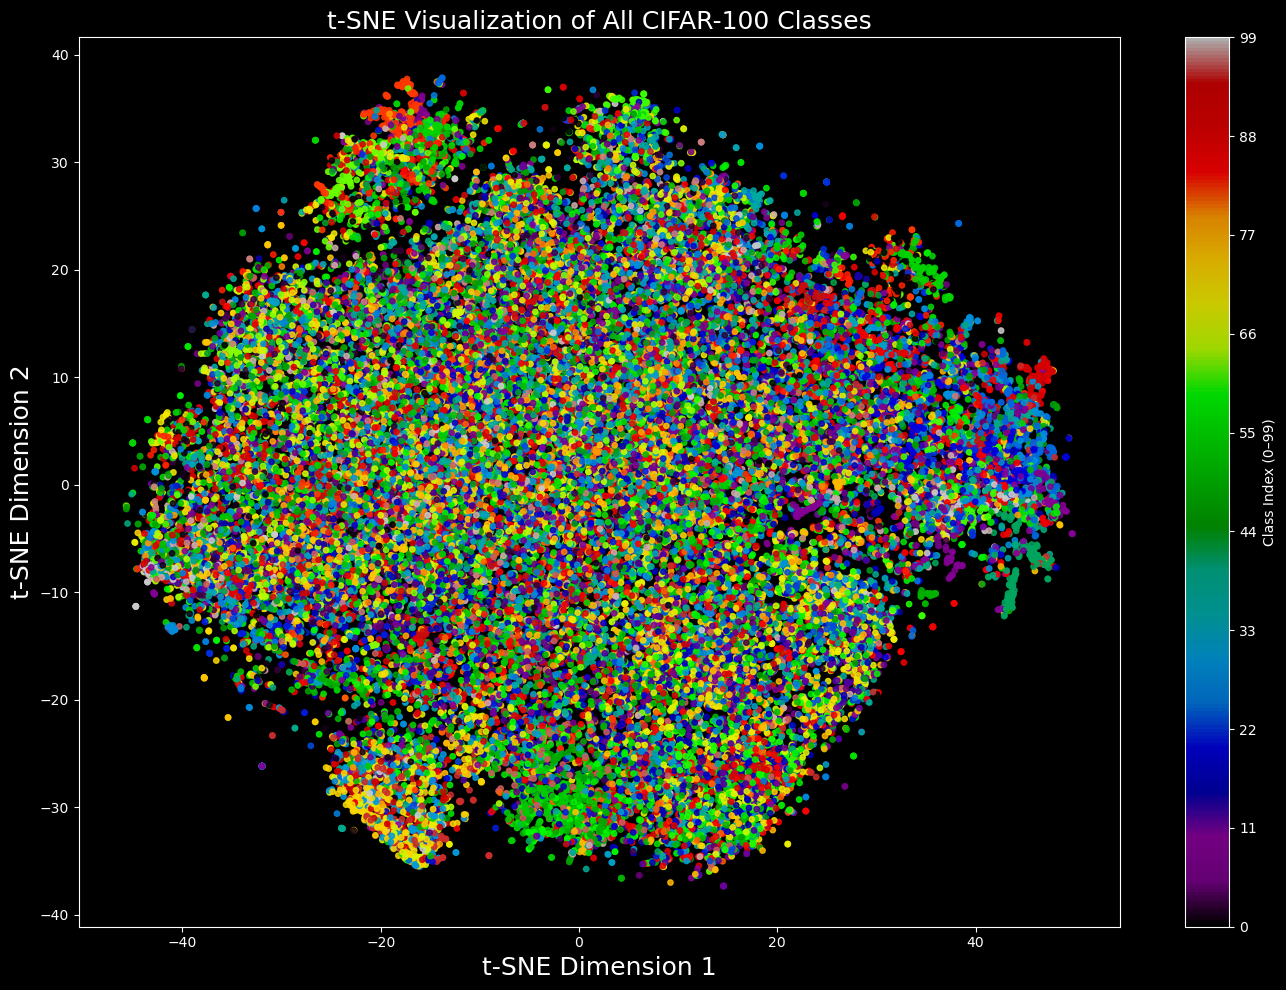

In [56]:
# Visualize CIFAR-100 with t-SNE
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

# Extract images and labels
images, labels = cifar100.data, np.array(cifar100.targets)

# Normalize images to [0, 1]
images = images.astype(np.float32) / 255.0

# Reshape images
images_flat = images.reshape(images.shape[0], -1)

# Scale features
scaler = StandardScaler()
images_scaled = scaler.fit_transform(images_flat)

print("Visualizing t-SNE for all CIFAR-100 classes...")
tsne_results = TSNE(n_components=2, perplexity=30, learning_rate=200, max_iter=1000, random_state=SEED)
tsne_results = tsne.fit_transform(images_scaled)

plt.style.use('dark_background')
colors_100 = plt.get_cmap('nipy_spectral')

# Create the scatter plot
plt.figure(figsize=(14, 10))
scatter = plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=labels, cmap=colors_100, s=15, alpha=0.85)

# Colorbar
cbar = plt.colorbar(scatter, ticks=np.linspace(0, 99, 10))
cbar.set_label('Class Index (0–99)', color='white')
cbar.ax.yaxis.set_tick_params(color='white')
plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color='white')

# Labels
plt.title("t-SNE Visualization of All CIFAR-100 Classes", color='white', fontsize=18)
plt.xlabel("t-SNE Dimension 1", color='white', fontsize=18)
plt.ylabel("t-SNE Dimension 2", color='white', fontsize=18)
plt.tick_params(colors='white')
plt.tight_layout()
plt.show()

Saved 3000 car images to ./cifar100_cars
Saved 3000 non-car images to ./cifar100_non_cars



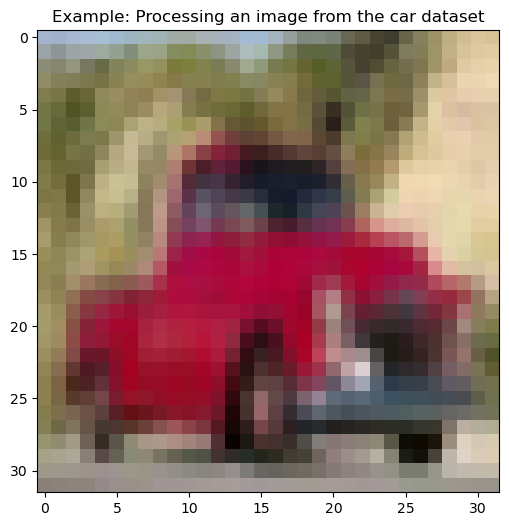

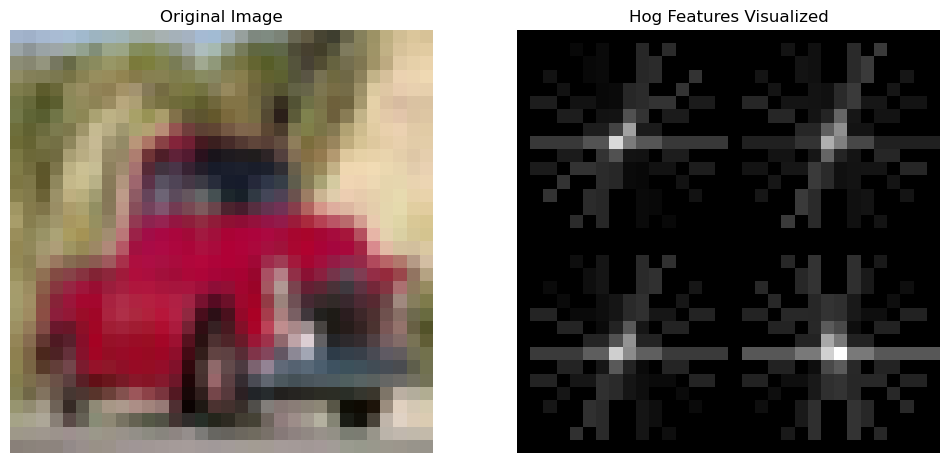


Begin extracting HOG features for positive and negative images (This will take a while)
Reading images and extracting features has taken 64.01 seconds
Shape of image set (6000, 540)
Shape of labels (6000,)

Split data into training and test sets
x_train: (4800, 540)
x_test: (1200, 540)
y_train: (4800,)
y_test: (1200,)

Creating an SVC object
[LibSVM]Accuracy score of model is  85.17


In [46]:
plt.style.use('default')

# Identify car-related class names
car_class_names = ['bicycle', 'bus', 'motorcycle', 'pickup_truck', 'streetcar', 'tractor']
car_indices = [cifar100.class_to_idx[name] for name in car_class_names]

# Output directory for car images
output_car_dir = './cifar100_cars'
os.makedirs(output_car_dir, exist_ok=True)

# Save only car images to directory
count = 0
for i in range(len(cifar100)):
    img, label = cifar100[i]
    if label in car_indices:
        img.save(os.path.join(output_car_dir, f"car_{count}.png"))
        count += 1

# Identify non-car class names
non_car_class_names = [class_name for class_name in cifar100.classes if class_name not in car_class_names]
non_car_indices = [cifar100.class_to_idx[name] for name in non_car_class_names]

# Output directory for non-car images
output_non_car_dir = './cifar100_non_cars'
os.makedirs(output_non_car_dir, exist_ok=True)

# Save 3000 random non-car images to directory
num_images = 3000
count_non_car = 0
sampled_images = []
non_car_indices_list = [i for i in range(len(cifar100)) if cifar100.targets[i] in non_car_indices]
random_indices = random.sample(non_car_indices_list, num_images)
for idx in random_indices:
    img, label = cifar100[idx]
    img.save(os.path.join(output_non_car_dir, f"non_car{count_non_car}.png"))
    count_non_car += 1

print(f"Saved {count} car images to {output_car_dir}")
print(f"Saved {count_non_car} non-car images to {output_non_car_dir}\n")

# Get file paths of saved car and non-car images
car_paths = glob(output_car_dir + "/*.png")
non_car_paths = glob(output_non_car_dir + "/*.png")

# Display example image from the car class
example_image = np.asarray(PIL.Image.open(car_paths[894]))
fig = plt.figure(figsize=(12, 6))

plt.title("Example: Processing an image from the car dataset")
plt.imshow(example_image)
example_image.shape

# Use HOG to focus on the shape of an image
hog_features, visualized = hog(image=example_image,
                               orientations=9,
                               pixels_per_cell=(16, 16),
                               cells_per_block=(2, 2),
                               visualize=True,
                               channel_axis=-1)

# Plot the original image
fig = plt.figure(figsize=(12, 6))
fig.add_subplot(1, 2, 1)
plt.imshow(example_image)
plt.title("Original Image")
plt.axis("off")

# Plot the HOG visualized image
fig.add_subplot(1, 2, 2)
plt.imshow(visualized, cmap="gray")
plt.title("Hog Features Visualized")
plt.axis("off")

plt.show()

# hog_features is a vector
hog_features.shape

pos_images = []
neg_images = []

# Labels: 1 for car, 0 for non-car
pos_labels = np.ones(len(car_paths))
neg_labels = np.zeros(len(non_car_paths))

# Start timer to measure processing time
start = time.time()
print("\nBegin extracting HOG features for positive and negative images (This will take a while)")

# Extract HOG features for positive images (cars)
for car_path in car_paths:
    img = np.asarray(PIL.Image.open(car_path))
    # We don't need RGB channels
    img = cv2.cvtColor(cv2.resize(img, (96,64)), cv2.COLOR_RGB2GRAY)
    img = hog(img, orientations=9, pixels_per_cell=(16, 16),cells_per_block=(2, 2))
    pos_images.append(img)
    
# Extract HOG features for negative images (non-cars)
for non_car_path in non_car_paths:
    img = np.asarray(PIL.Image.open(non_car_path))
    img = cv2.cvtColor(cv2.resize(img, (96,64)), cv2.COLOR_RGB2GRAY)
    img = hog(img, orientations=9, pixels_per_cell=(16, 16),cells_per_block=(2, 2))
    neg_images.append(img)

# Stack positive and negative images
x = np.asarray(pos_images + neg_images)
y = np.asarray(list(pos_labels) + list(neg_labels))

processTime = round(time.time()-start, 2)
print(f"Reading images and extracting features has taken {processTime} seconds")

print("Shape of image set", x.shape)
print("Shape of labels", y.shape)

"""
Split data into train and test
"""

print("\nSplit data into training and test sets")
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=SEED)
print(f"x_train: {x_train.shape}")
print(f"x_test: {x_test.shape}")
print(f"y_train: {y_train.shape}")
print(f"y_test: {y_test.shape}")

# Creating a SVC object
print("\nCreating an SVC object")
svc = SVC(kernel = 'rbf', verbose=True, random_state=SEED)

# Fit the training dataset
svc.fit(x_train, y_train)

y_pred = svc.predict(x_test)
print("Accuracy score of model is ",round(accuracy_score(y_pred=y_pred,y_true=y_test)*100, 2))


Test multiple images
True label:  Not car
Prediction: Not car


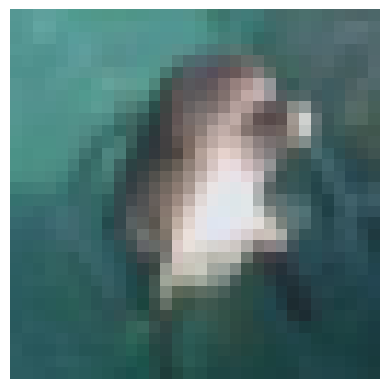

True label:  Car
Prediction: Car


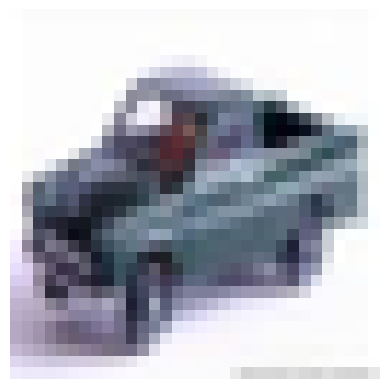

True label:  Car
Prediction: Car


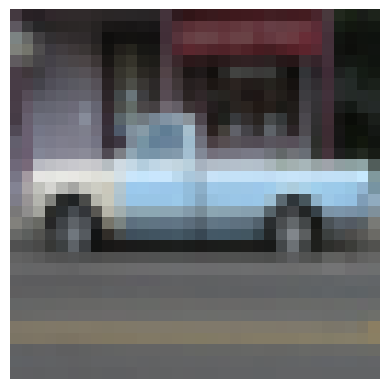

True label:  Not car
Prediction: Not car


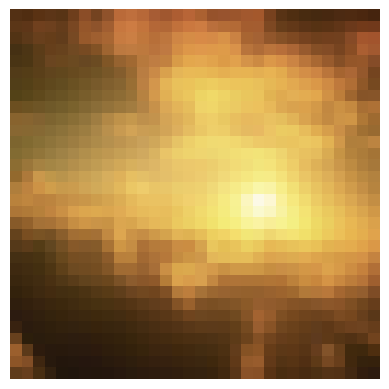

In [56]:
# Test a model's prediction on a single image
def test_prediction(img_path, true_label, svc):
    img = np.asarray(PIL.Image.open(img_path))
    img_gray = cv2.cvtColor(cv2.resize(img, (96, 64)), cv2.COLOR_RGB2GRAY)
    image, viz = hog(img_gray, orientations=9, pixels_per_cell=(16,16), cells_per_block=(2,2), visualize=True)

    x_tst = np.asarray(image)
    pred = svc.predict([x_tst])

    print("True label: ", true_label)
    
    if pred[0] == 0.0:
        print("Prediction: Not car")
        
    elif pred[0] == 1.0:
        print("Prediction: Car")
        
    plt.imshow(img)
    plt.axis("off")
    plt.show()

print("\nTest multiple images")
test_prediction(non_car_paths[479], "Not car", svc)
test_prediction(car_paths[1300], "Car", svc)
test_prediction(car_paths[10], "Car", svc)
test_prediction(non_car_paths[-78], "Not car", svc)

Starting hyperparameter tuning...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
[LibSVM]
Best Parameters: {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
Best Cross-Validation Accuracy: 85.25
Test Accuracy of Best Model: 85.17


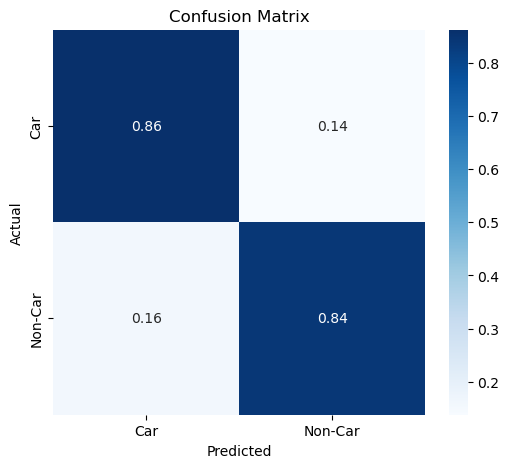

In [58]:
"""
Hyperparameter Tuning
"""

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, recall_score

car_recall_scorer = make_scorer(recall_score, pos_label=1)

# Define parameter grid
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],    # Regularization strength
    'kernel': ['linear', 'rbf'],     # Linear and RBF kernels
    'gamma': ['scale', 'auto']
}

# Set up GridSearchCV
grid_search = GridSearchCV(estimator=svc, param_grid=param_grid, scoring=car_recall_scorer, cv=5, verbose=2, n_jobs=-1)

# Fit grid search to training data
print("Starting hyperparameter tuning...")
grid_search.fit(x_train, y_train)

# Best model and parameters
print("\nBest Parameters:", grid_search.best_params_)
print("Best Cross-Validation Accuracy:", round(grid_search.best_score_ * 100, 2))

# Evaluate on test set
best_model = grid_search.best_estimator_
y_pred = best_model.predict(x_test)
test_acc = accuracy_score(y_test, y_pred)
print("Test Accuracy of Best Model:", round(test_acc * 100, 2))

# Plot Normalize Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(6, 5))
sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap="Blues", xticklabels=["Car", "Non-Car"], yticklabels=["Car", "Non-Car"])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

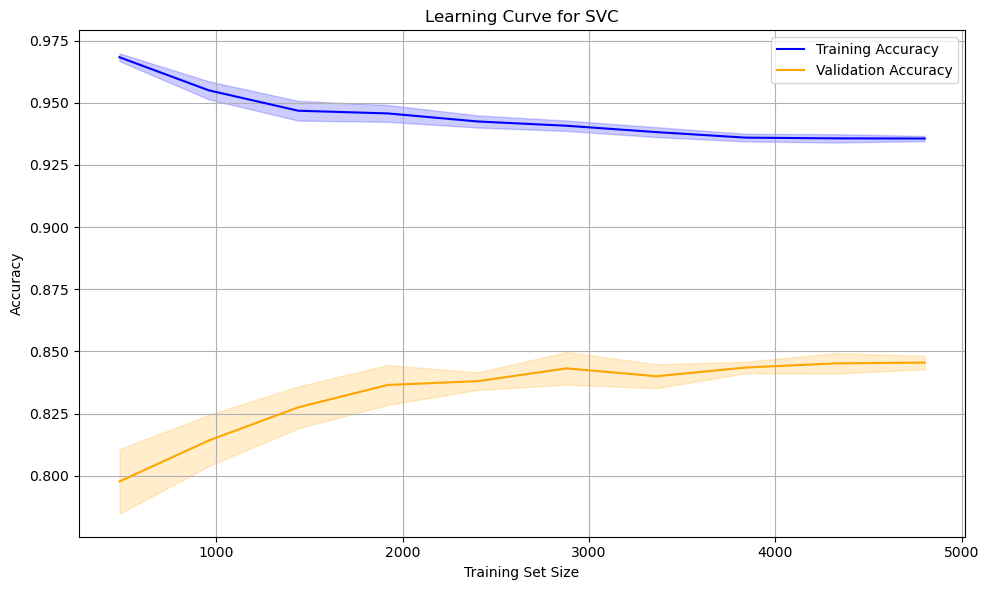

In [60]:
from sklearn.decomposition import PCA
from sklearn.model_selection import learning_curve

# Use the best model if available; otherwise use the original SVC
model_to_plot = grid_search.best_estimator_ if 'grid_search' in locals() else svc

# Generate learning curve data
train_sizes, train_scores, val_scores = learning_curve(
    estimator=model_to_plot,
    X=x_pca,
    y=y,
    train_sizes=np.linspace(0.1, 1.0, 10),
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    shuffle=True,
    random_state=SEED
)

# Compute mean and std for plotting
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
val_scores_mean = np.mean(val_scores, axis=1)
val_scores_std = np.std(val_scores, axis=1)

# Plot learning curves
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, label='Training Accuracy', color='blue')
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.2, color='blue')

plt.plot(train_sizes, val_scores_mean, label='Validation Accuracy', color='orange')
plt.fill_between(train_sizes, val_scores_mean - val_scores_std, val_scores_mean + val_scores_std, alpha=0.2, color='orange')

plt.title('Learning Curve for SVC')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()